# Heart rate and Breathing Rate from Photoplethysmography (PPG)

Our goal is to measure blood flow by measuring light reflection from the finger. The process is shown in the figure below. You hold the finger to the phone's camera with the LED turned on. The amplitude of the reflected light is  proportional to pulse pressure – the higher the peak, the stronger the pulse. 

<img src="figures/phone-ppg.jpg" width=500>

## PPG Example

An example of the PPG signal is shown below. This is a very clean example -- in practice, the PPG signal has baseline changes due to breathing and can be noisy due to leakage from ambient light. 

<img src="figures/ppg-signal.png" width=500>

## PPG Processing Pipeline

The PPG processing pipeline to extract heartrate and breathing rate is shown below. To extract heart rate, you take the higher frequency components and to extract breathing rate, you filter out the heart rate signal and take the lower frequency components.

<img src="figures/ppg-pipeline.png" width=900>

In this assignment, you will essentially follow the above pipeline and come up with an estimate for the heart rate and breathing rate in the time interval for which you have been provided the PPG signal.

In [16]:
import matplotlib
from matplotlib import cm
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import scipy.signal as sps
from scipy.signal import butter, lfilter, freqz, iirnotch, filtfilt, firwin, find_peaks

matplotlib.style.use('ggplot')
%matplotlib notebook
#test

In [17]:
def pull_data(dir_name, file_name):
    f = open(dir_name + '/' + file_name + '.csv')
    x = []
    timestamps = []
    for line in f:
        value = line.split(',')
        if len(value) > 1:
            timestamps.append(float(value[-2]))
            p = float(value[-1])
            x.append(p)
    c = timestamps[0]
    timestamps[:] = [(y - c)/1000 for y in timestamps]
    return np.array(x), np.array(timestamps)


## Part 1: Extracting Heart Rate from PPG

First, let us extract the heart rate signal from the data. The raw PPG signal has both the breathing and heartrate signal mixed together, so you need to find a way to separate these two signals to extract these values individually. Let us first look at how to extract heartrate from the PPG signal.

The heartrate signal corresponds to the small peaks that are continuously embedded in the signal. To extract the heartrate signal, you need to first subtract the baseline to get a clean periodic signal and then extract each individual heartbeat cycle.


<IPython.core.display.Javascript object>


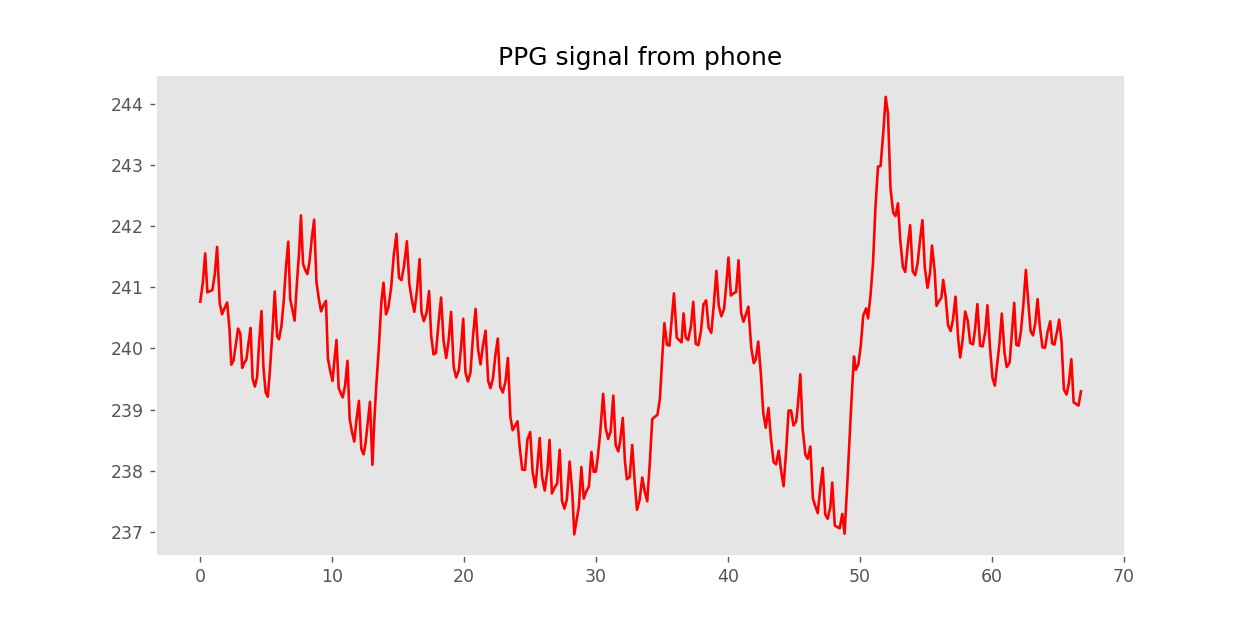

In [18]:
# read accelerometer data file
ppg_file = 'data/PPG'
signal, timestamps = pull_data(ppg_file, 'ppg_readings')
sampling_rate = len(timestamps)/max(timestamps)

plt.figure(figsize=(10,5))
plt.plot(timestamps, signal, 'r-',label='PPG')
plt.title("PPG signal from phone")
pl.grid()
pl.show()

**NOTE:** You have not been provided with exactly one minute of data, which means the heart rate and breathing rate in their standard units are not numerically equal to the number of heart beats or breaths detected in this interval. Take note of this in your calculations and in reporting your estimated results.

### 1.1 Extract Heart Rate signal via High-pass Filtering

**ASSIGNMENT:** Implement a high-pass filter to extract the heart rate signal from the noisy signal provided to you. For guidelines, you can refer to the implementation of the Butterworth filter in previous notebooks (recall that the Butterworth filter is actually a low-pass filter - you will have to modify your implementation accordingly). Set the cutoff frequency of the filter as appropriate. You can compare your resultant signal with the sample graph provided in the assignment instructions to tune the cutoff frequency.

Plot the original and high-pass filtered signals on the same graph for comparison.

In [19]:
# FILL IN CODE: Implement high-pass filter 0.05 to 0.5 Hz, low pass recommended 40,100,150, butterworth
# Filter requirements.
order = 4
fs = 125.0  # sample rate, Hz
cutoff =8  # desired cutoff frequency of the filter, Hz. MODIFY AS APPROPROATE

# Create the filter.
nyq = 0.5 * fs #nyquist frequency will usually be 0.5
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='highpass', analog=False)

filtered_signal = filtfilt(b, a, signal)  

<IPython.core.display.Javascript object>


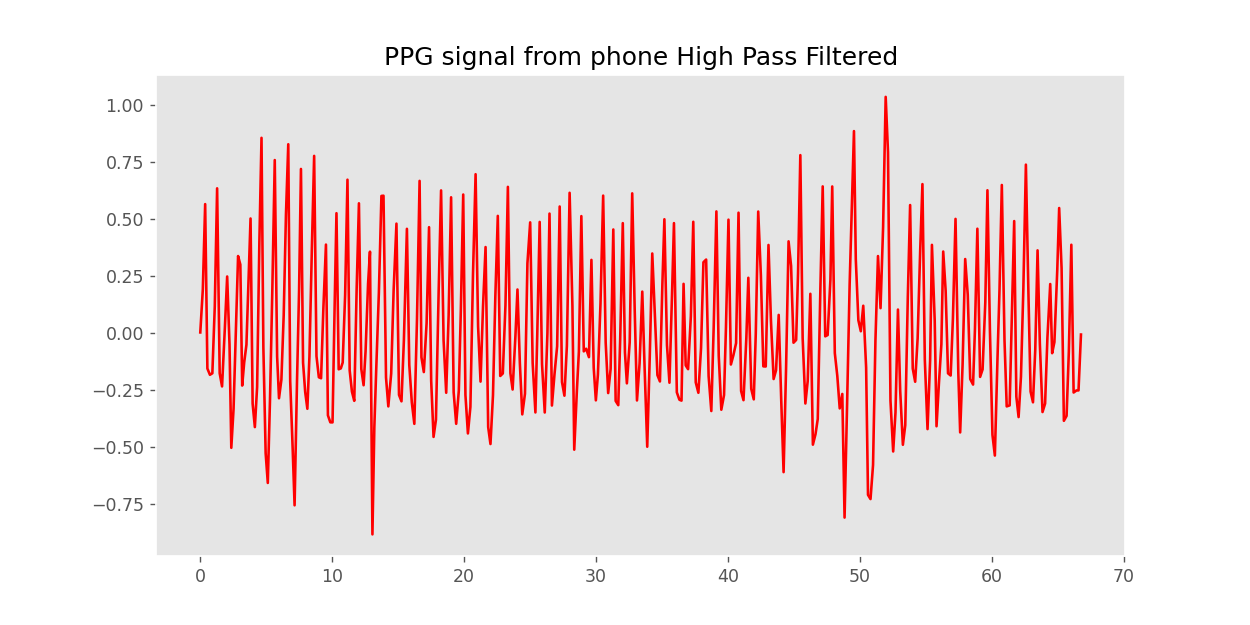

In [20]:
# FILL IN CODE: Plot the required signals 
plt.figure(figsize=(10,5))
plt.plot(timestamps, filtered_signal, 'r-',label='PPG')
plt.title("PPG signal from phone High Pass Filtered")
pl.grid()
pl.show()
#you can compare this with the word doc example

### 1.2 Extract heart rate from the filtered signal

**ASSIGNMENT:** Use the highpass filtered signal from the previous step to estimate heart rate. You may try to apply algorithms similar to the step counting part of the assignment.

Plot your filtered signal and add markers at the points where your algorithm detects a heartbeat. Also print the estimated heartrate.

<IPython.core.display.Javascript object>


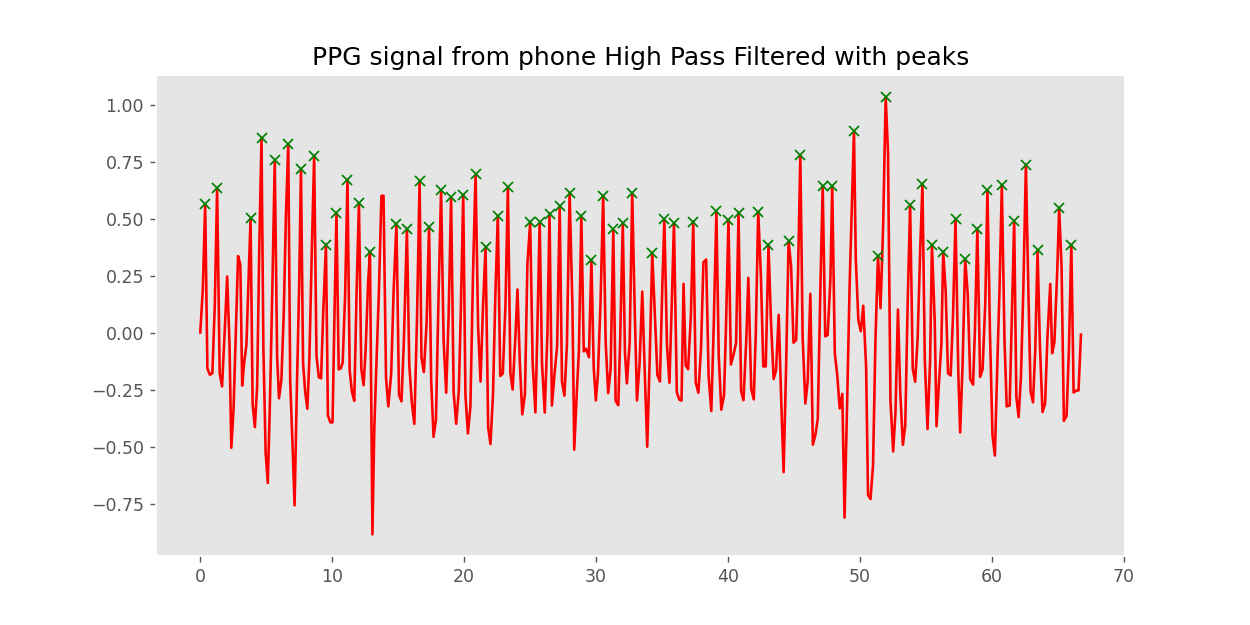

In [27]:
# FILL IN WITH CODE TO EXTRACT HEART RATE AND PLOT RESULTS
findPeaks,_ = sps.find_peaks(filtered_signal, height = .3, threshold = .1)
plt.figure(figsize=(10,5))
plt.plot(timestamps, filtered_signal, 'r-',label='PPG with heart rate peaks')
plt.plot(timestamps[findPeaks], filtered_signal[findPeaks], "x", color = "g")
plt.title("PPG signal from phone High Pass Filtered with peaks")
pl.grid()
pl.show()

In [31]:
# Print estimated heart rate (in beats/minute, bpm)
print("Number of heart beats per min")
print(len(findPeaks) - 6) # there are 6 extra beats between seconds 60 and 70

Number of heart beats per min
59


## Part 2: Extract Breathing Rate from PPG

Extracting the breathing rate from the PPG signal is somewhat harder than extracting the heartrate since the peaks in the breathing signal are not always clearly visible. However, this information is indeed contained in the waveform. 

To extract the breathing signal, we follow three steps. 

<ol>
<li> First, we use a notch filter to remove frequencies near the heart rate that we just estimated. This is a targeted way of removing the heart rate signal.
<li> Second, we use a low-pass filter to extract only the baseline signal and remove residual heartrate signal. This baseline has the breathing signal (in the form of peaks) but it is often swamped by the changing baseline.  
<li> Third, you need to do peak detection to extract the breathing waveform. Note that since there is baseline wander, we cannot use zero crossings and instead have to rely on the local peaks.
</ol>

### 2.1 Use notch filter to remove heart rate signal

The notch filter removes the estimated heart rate (from above). Since the heart rate varies a little bit within the minute window, we use a low quality factor for the notch filter so that it removes a band of frequencies in the vicinity of the estimated heart rate.

**ASSIGNMENT:** Create and apply a notch filter (see previous notebooks for help) to remove the heart rate estimated above. Note that the filter requires a frequency in Hz, convert your heart rate estimate accordingly. Use a quality factor of 1.

In [23]:
# FILL IN CODE to apply a notch filter.

**ASSIGNMENT:** Plot the signal before and after application of notch filter on the same graph.

In [24]:
# FILL IN CODE to plot original and filtered signals.

### 2.2 Use lowpass filter to remove residual high frequency noise

The low pass filter is used to remove any residual heart rate signal since the notch filter may not remove all of it. Other sources of high frequency noise are also removed.

**ASSIGNMENT:** Implement a lowpass filter and apply it to the notch-filtered signal. You will need to adjust the parameters as appropriate. Plot the original signal (before application of notch filter) and the notch+lowpass filtered signal. You may compare with the sample graph in the assignment instructions to adjust filter parameters (note that the resultant signal will vary with the estimated heartrate, since that was a parameter in the notch filter).

In [25]:
# FILL IN CODE to apply lowpass filter, butterworth
#can compare with word doc example

### 2.3 Estimating breathing rate

The final step is to estimate the breathing rate. Note that the signal has a wandering baseline, so you need to choose your estimation algorithm accordingly. Do not expect to see a very clean breathing signal - you should expect to see something noisy like this.

<img src="figures/breathing.png" width=500>

**ASSIGNMENT:** Estimate the breathing rate from the highpass-filtered signal from the previous step. Also plot your filtered signal with markers at the points determined to be breaths by your algorithm. Print the estimated breathing rate.

In [26]:
# FILL IN CODE TO ESTIMATE BREATHING RATE AND PLOT RESULTS

**NOTE:** Once you complete the assignment, click on Kernel > Restart & run all. Make sure all your code runs without errors and the plots and print statements are properly visible. Then save the notebook, add your changes to Git and commit and push before the deadline.